In [1]:
from rbi.utils.tasks import LotkaVolterraTask, SquareTask
import matplotlib.pyplot as plt
import torch

In [2]:
task = SquareTask(prior_scale=2, likelihood_scale=1.)

In [4]:
task.output_dim

4

In [127]:
prior = task.get_prior()
simulator = task.get_simulator()
loglikelihood = task.get_loglikelihood_fn()
potential_fn = task.get_potential_fn()

In [128]:
l = torch.randn(10, 100)
s = torch.randn(5, 10, 4)

potential_fn(l, s).shape

torch.Size([5, 10])

In [16]:
(loglikelihood(s).log_prob(l) + prior.log_prob(s)).shape

torch.Size([10, 1])

In [26]:
true_post = task.get_true_posterior_logprob_fn(torch.tensor([10.]))

In [27]:
true_post(torch.linspace(-5, 5, 1000).reshape(-1,1)).shape

torch.Size([1, 1000, 1])

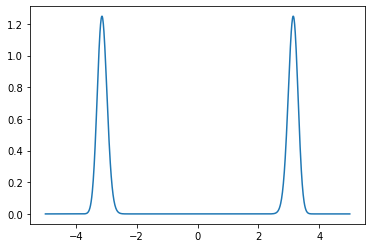

In [29]:
plt.plot(torch.linspace(-5, 5, 1000),true_post(torch.linspace(-5, 5, 1000).reshape(-1,1)).flatten().exp())

In [3]:
thetas = prior.sample((50,))
x = simulator(thetas)

NameError: name 'prior' is not defined

In [4]:
train_loader, _ ,_ = task.get_train_test_val_dataset(5000, 100, None, batch_size=1000)

In [66]:
from rbi.utils.nets import SplineAutoregressiveModel, MixtureDiagGaussianModel
import torch
from rbi.loss.loss_fn import NegativeElboLoss
net = SplineAutoregressiveModel(1, 1, num_transforms=1, count_bins=20, bound=10, hidden_dims=[100, 100])
loss_fn = NegativeElboLoss(net, task.get_potential_fn(), task.get_loglikelihood_fn(), n_particles=4)

c:\ProgramData\Miniconda3\lib\site-packages\pyro\nn\auto_reg_nn.py:179: UserWarning: ConditionalAutoRegressiveNN input_dim = 1. Consider using an affine transformation instead.
  warnings.warn(


In [68]:
optim = torch.optim.Adam(net.parameters(), lr=1e-3)
for i in range(20):
    for x, theta in train_loader:
        optim.zero_grad()
        l = loss_fn(x, theta)
        l.backward()
        optim.step()
    print(l)



tensor([5.3722], grad_fn=<AddBackward0>)
tensor([3.4644], grad_fn=<AddBackward0>)
tensor([4.5749], grad_fn=<AddBackward0>)
tensor([4.1415], grad_fn=<AddBackward0>)
tensor([3.4850], grad_fn=<AddBackward0>)
tensor([3.2433], grad_fn=<AddBackward0>)
tensor([3.2327], grad_fn=<AddBackward0>)
tensor([2.9492], grad_fn=<AddBackward0>)
tensor([2.9030], grad_fn=<AddBackward0>)
tensor([2.9972], grad_fn=<AddBackward0>)
tensor([2.9714], grad_fn=<AddBackward0>)
tensor([2.9964], grad_fn=<AddBackward0>)
tensor([3.0053], grad_fn=<AddBackward0>)
tensor([2.9305], grad_fn=<AddBackward0>)
tensor([2.9928], grad_fn=<AddBackward0>)
tensor([2.9139], grad_fn=<AddBackward0>)
tensor([2.8273], grad_fn=<AddBackward0>)
tensor([2.8920], grad_fn=<AddBackward0>)
tensor([2.9193], grad_fn=<AddBackward0>)
tensor([2.9234], grad_fn=<AddBackward0>)


In [78]:
true_post = task.get_potential_fn()

In [79]:
theta_o = torch.tensor([1.3])
x_o = simulator(theta_o)
post = net(x_o)

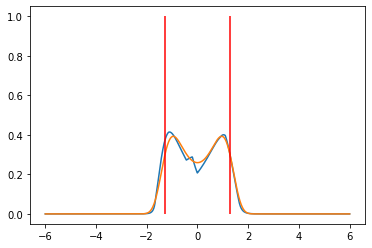

In [80]:
x = torch.linspace(-6,6, 1000)
logq = post.log_prob(x.reshape(-1,1)).flatten().detach()
logp = true_post(x_o, x.reshape(-1,1)).exp()
logp /= torch.trapz(logp.flatten(), x.flatten())
plt.plot(x, logq.exp())
plt.plot(x, logp.flatten())
plt.vlines(theta_o, 0, 1, color="red")
plt.vlines(-theta_o, 0, 1, color="red")

In [82]:
net2 = SplineAutoregressiveModel(1, 1, num_transforms=1, count_bins=20, bound=10, hidden_dims=[100, 100])
loss_fn = NegativeElboLoss(net2, task.get_potential_fn(), task.get_loglikelihood_fn(), n_particles=4)

In [85]:
optim = torch.optim.Adam(net2.parameters(), lr=1e-3)
for i in range(20):
    for x, theta in train_loader:
        optim.zero_grad()
        l = loss_fn(x + torch.randn_like(x)*2, theta)
        l.backward()
        optim.step()
    print(l)



tensor([13.4043], grad_fn=<AddBackward0>)
tensor([8.6313], grad_fn=<AddBackward0>)
tensor([5.4976], grad_fn=<AddBackward0>)
tensor([4.0138], grad_fn=<AddBackward0>)
tensor([3.7517], grad_fn=<AddBackward0>)
tensor([3.8230], grad_fn=<AddBackward0>)
tensor([3.7095], grad_fn=<AddBackward0>)
tensor([3.7073], grad_fn=<AddBackward0>)
tensor([3.6249], grad_fn=<AddBackward0>)
tensor([3.6602], grad_fn=<AddBackward0>)
tensor([3.6329], grad_fn=<AddBackward0>)
tensor([3.5957], grad_fn=<AddBackward0>)
tensor([3.5898], grad_fn=<AddBackward0>)
tensor([3.6039], grad_fn=<AddBackward0>)
tensor([3.6642], grad_fn=<AddBackward0>)
tensor([3.6226], grad_fn=<AddBackward0>)
tensor([3.5484], grad_fn=<AddBackward0>)
tensor([3.6230], grad_fn=<AddBackward0>)
tensor([3.6048], grad_fn=<AddBackward0>)
tensor([3.5051], grad_fn=<AddBackward0>)


In [88]:
post = net2(x_o)

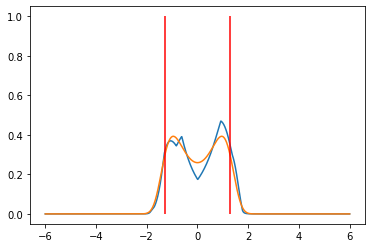

In [89]:
x = torch.linspace(-6,6, 1000)
logq = post.log_prob(x.reshape(-1,1)).flatten().detach()
logp = true_post(x_o, x.reshape(-1,1)).exp()
logp /= torch.trapz(logp.flatten(), x.flatten())
plt.plot(x, logq.exp())
plt.plot(x, logp.flatten())
plt.vlines(theta_o, 0, 1, color="red")
plt.vlines(-theta_o, 0, 1, color="red")

In [120]:
from rbi.loss.loss_fn import NLLLoss
net3 = SplineAutoregressiveModel(1, 1, num_transforms=1, count_bins=20, bound=10, hidden_dims=[100, 100])
loss_fn = NLLLoss(net3)

c:\ProgramData\Miniconda3\lib\site-packages\pyro\nn\auto_reg_nn.py:179: UserWarning: ConditionalAutoRegressiveNN input_dim = 1. Consider using an affine transformation instead.
  warnings.warn(


In [125]:
loss_fn.training

False

In [124]:
loss_fn.eval()

NLLLoss(
  (model): SplineAutoregressiveModel(
    (embedding_net): Identity()
    (t0): ConditionalSplineAutoregressive(
      (nn): ConditionalAutoRegressiveNN(
        (layers): ModuleList(
          (0): MaskedLinear(in_features=2, out_features=100, bias=True)
          (1): MaskedLinear(in_features=100, out_features=100, bias=True)
          (2): MaskedLinear(in_features=100, out_features=79, bias=True)
        )
        (f): ReLU()
      )
    )
  )
)

In [105]:
optim = torch.optim.Adam(net3.parameters(), lr=1e-3)
for i in range(20):
    for x, theta in train_loader:
        optim.zero_grad()
        l = loss_fn(x + torch.randn_like(x)*2, theta)
        l.backward()
        optim.step()
    print(l)



tensor([1.3834], grad_fn=<AddBackward0>)
tensor([1.4256], grad_fn=<AddBackward0>)
tensor([1.4354], grad_fn=<AddBackward0>)
tensor([1.3968], grad_fn=<AddBackward0>)
tensor([1.3886], grad_fn=<AddBackward0>)
tensor([1.3892], grad_fn=<AddBackward0>)
tensor([1.4133], grad_fn=<AddBackward0>)
tensor([1.3839], grad_fn=<AddBackward0>)
tensor([1.3720], grad_fn=<AddBackward0>)
tensor([1.4116], grad_fn=<AddBackward0>)
tensor([1.3867], grad_fn=<AddBackward0>)
tensor([1.3912], grad_fn=<AddBackward0>)
tensor([1.3739], grad_fn=<AddBackward0>)
tensor([1.3665], grad_fn=<AddBackward0>)
tensor([1.3924], grad_fn=<AddBackward0>)
tensor([1.3652], grad_fn=<AddBackward0>)
tensor([1.3841], grad_fn=<AddBackward0>)
tensor([1.3835], grad_fn=<AddBackward0>)
tensor([1.3902], grad_fn=<AddBackward0>)
tensor([1.4762], grad_fn=<AddBackward0>)


In [106]:
post = net3(x_o)
x = torch.linspace(-6,6, 1000)
task_perturbed = SquareTask(prior_scale=2, likelihood_scale=3.)
true_post2 = task_perturbed.get_potential_fn()
logp2 = true_post2(x_o, x.reshape(-1,1)).exp()
logp2 /= torch.trapz(logp2.flatten(), x.flatten())

In [114]:
torch.save(net, "test")

In [113]:
net.input_transform = None

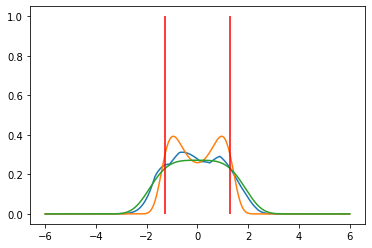

In [107]:

logq = post.log_prob(x.reshape(-1,1)).flatten().detach()
logp = true_post(x_o, x.reshape(-1,1)).exp()
logp /= torch.trapz(logp.flatten(), x.flatten())
plt.plot(x, logq.exp())
plt.plot(x, logp.flatten())
plt.plot(x, logp2.flatten())
plt.vlines(theta_o, 0, 1, color="red")
plt.vlines(-theta_o, 0, 1, color="red")

In [47]:
task = LotkaVolterraTask(observation_noise=1., prior_scale=0.5, odeint_kwargs={"method": "euler", "options":{"step_size":5e-4}})

prior = task.get_prior()
simulator = task.get_simulator()
loglikelihood = task.get_loglikelihood_fn()
potential_fn = task.get_potential_fn()

In [48]:
train_loader, _ ,_ = task.get_train_test_val_dataset(1000, 100, None, batch_size=100)

In [51]:
from rbi.utils.nets import SplineAutoregressiveModel, MixtureDiagGaussianModel, IndependentGaussianNet, AffineAutoregressiveModel
import torch
from rbi.loss.loss_fn import NegativeElboLoss
net = AffineAutoregressiveModel(100, 4, hidden_dims=[100, 100], num_transforms=2)
loss_fn = NegativeElboLoss(net, task.get_potential_fn(), task.get_loglikelihood_fn(), n_particles=1)

In [52]:
loss_fn(x, theta)

tensor([44524.6719], grad_fn=<AddBackward0>)

In [41]:
simulator(net(x).sample()).max()

tensor(22942.1133)

In [53]:
optim = torch.optim.Adam(net.parameters(), lr=1e-9)
for i in range(20):
    for x, theta in train_loader:
        optim.zero_grad()
        l = loss_fn(x, theta)
        l.backward()
        optim.step()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 1.)
        print(l)



tensor([20144.7051], grad_fn=<AddBackward0>)


ValueError: Expected value argument (Tensor of shape (1, 100, 4)) to be within the support (Real()) of the distribution Normal(loc: torch.Size([4]), scale: torch.Size([4])), but found invalid values:
tensor([[[nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan],
         [nan, nan, nan, nan]]], grad_fn=<IndexSelectBackward0>)